# Workflow for intensity standardization of bone scintigraphy scans

**References:**

[1] Nyúl, László G., and Jayaram K. Udupa. "On standardizing the MR image intensity scale" Magn Reson Med. (1999) Dec;42(6):1072-81.

[2] Shah, Mohak, et al. "Evaluating intensity normalization on MRIs of human brain with multiple sclerosis" Medical image analysis 15.2 (2011): 267-282.

**Acknowledgements (code implementation):**
- https://github.com/sergivalverde/MRI_intensity_normalization
- https://github.com/jcreinhold/intensity-normalization
- https://gitlab.com/eferrante/nyul/-/tree/c01ad9afc89e9de18cd5ff911877bcbf49777476

### Table of Contents

* [Problem statement](#chapter1)
* [Python modules](#chapter2)
* [Load data](#chapter3)
* [Data visualization](#chapter4)
* [Training - Learn the standard scale](#chapter5)
* [Transformation - Apply the standard scale](#chapter6)
* [Results](#chapter7)
    * [Nyul normalization](#section7_1)
    * [Thresholding the minimum and maximum intensity value to the median](#section7_2)
    * [Recap](#section7_3)

## Problem statement <a class="anchor" id="chapter1"></a>

A common problem in medical image analysis (especially in functional imaging modalities such as MRI, PET and Scintigraphy) is the lack of a standardized intensity range throughout a dataset. Medical image analysis, in particular automated approaches, strongly relies on the shape of the underlying distribution of various tissue type intensities. 

The reason for that is that there are certain variabilities in the acquisition of the images, e.g., different scanners (vendors), reconstruction algorithms and acquisition protocols. Even for the same scanner and protocol, the intensity ranges might vary significantly. 

Especially in nuclear medicine, where the acquisition depends on the administration and distribution of a radiotracer, there is always a certain intrinsic variability in the intensity range, because the intensity of the obtained image corresponds to the activity distribution of the administered radiotracer.

Hence, intensity standardization, i.e. scaling the intensities to a common standard scale <=> normalizing the input images to a standard scale is an important pre-processing step in the (automated) analysis of medical images. 

There are several normalization methods (refer to: [arXiv:1812.04652](https://arxiv.org/abs/1812.04652)) and code implementations available. However, the code implementations mentioned above are built for MRI brain scans.

We will use the method by Nyul et al. because it is a fast, accurate and easy to implement way to normalize various kinds of medical images. Please refer to [1] and [2] for a detailed explanation on how the standardization method by Nyul et al. works.

## Python modules <a class="anchor" id="chapter2"></a>

For this notebook, the modules below are required and need to be imported:

In [1]:
import numpy as np
import os
from natsort import natsorted  # natural sorting
from matplotlib import pyplot as plt
import nyul  # local file
from tqdm import tqdm  # progressbar

plt.rcParams['image.cmap'] = 'gray_r'
plt.style.use('seaborn-ticks')

## Load data <a class="anchor" id="chapter3"></a>

For this demo, we are using a dataset consisting of 5057 bone scintigraphy scans. However, we will only load the first 50 scans for a better distinguishability in the plots:

In [2]:
# Path to data directory
path = os.path.join(os.getcwd(), 'data')

# Create dict to store unique IDs, original images and normalized images (later)
data = {'uids': [], 'orig': [], 'norm': []}

for index, file in enumerate(natsorted(os.listdir(path))):
    if not file.startswith('.'):
        img = np.load(os.path.join(path, file))
        data['orig'].append(img)
        data['uids'].append(file.rstrip('.npy'))
        
        if index >= 50:
            break
            
print('Number of scans: ', len(data['orig']))

Number of scans:  50


## Data visualization <a class="anchor" id="chapter4"></a>

Before we start with the standardization, lets have a look at the data we are working with. It will help us to understand the problem more intuitively.

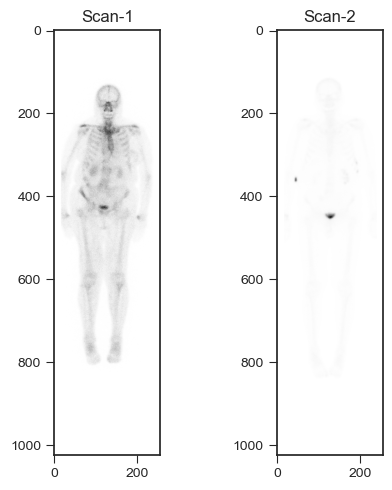

In [3]:
# Select two scans as example
orig_example = dict(zip(data['uids'], data['orig']))
scan1 = 'img-24'
scan2 = 'img-30'

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(orig_example[scan1])
ax[0].set_title('Scan-1')
ax[1].imshow(orig_example[scan2])
ax[1].set_title('Scan-2')
plt.tight_layout()
plt.show()

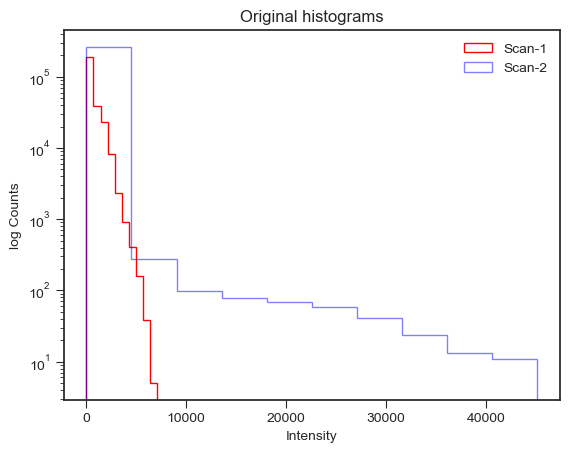

In [4]:
# Plot image histograms
plt.hist(orig_example[scan1].flatten(), histtype='step', ec='r', label='Scan-1')
plt.hist(orig_example[scan2].flatten(), histtype='step', ec='b', alpha=0.5, label='Scan-2')
plt.yscale('log')
plt.xlabel('Intensity')
plt.ylabel('log Counts')
plt.legend()
plt.title('Original histograms')
plt.show()

As one can clearly see, the two example scans have quite a different intensity and contrast range, which would be an issue in an automated analysis approach.

Lets plot the intensity histograms of all 50 scans:

100%|██████████| 50/50 [00:00<00:00, 242.16it/s]


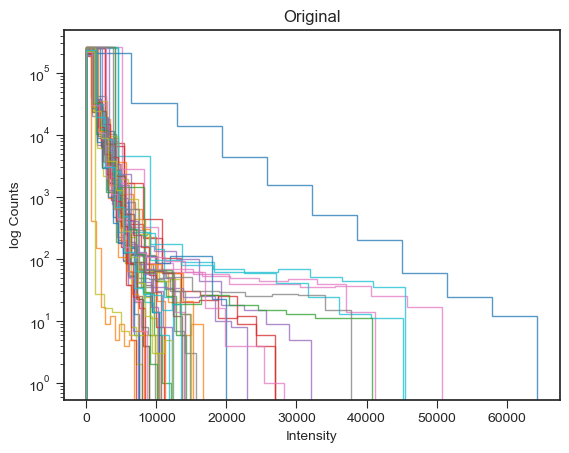

In [5]:
for img_orig in tqdm(data['orig']):
    plt.hist(img_orig.flatten(), histtype='step', alpha=0.75)
plt.xlabel('Intensity')
plt.ylabel('log Counts')
plt.yscale('log')
plt.title('Original')
plt.show()

100%|██████████| 50/50 [00:00<00:00, 5917.14it/s]


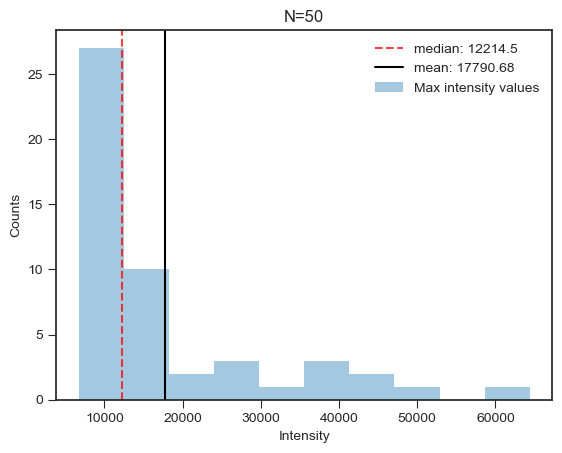

Min: 	 6730
Max: 	 64385
Delta: 	 57655


In [6]:
max_intensity = []
for img_orig in tqdm(data['orig']):
    max_intensity.append(np.max(img_orig))

plt.hist(max_intensity, alpha=0.4, label='Max intensity values')
plt.axvline(np.median(max_intensity), color='r', linestyle='dashed', alpha=0.75, label='median: {}'.format(np.median(max_intensity)))
plt.axvline(np.mean(max_intensity), color='black', label='mean: {}'.format(np.mean(max_intensity)))
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.legend()
plt.title('N=50')
plt.show()

print('Min: \t', np.min(max_intensity))
print('Max: \t', np.max(max_intensity))
print('Delta: \t', np.max(max_intensity)-np.min(max_intensity))

The maximum intensity values lie in a range between 6730 and 57655.

## Training - Learn the standard scale <a class="anchor" id="chapter5"></a>

Start the training process. The term *training* might be a bit confusing, since there will be no actual machine learning method applied. However, we will follow this terminology as it was proposed initially in the original publication by Nyul et al. 

During training, the histogram landmarks of the training images will be extracted. We will save the standard scale and the used percentiles as a numpy file.

In [7]:
# Train
standard_scale, percs = nyul.learn_standard_scale(data['orig'])

# Save standard scale and used percentiles
np.save('standard_scale.npy', [standard_scale, percs])

100%|██████████| 50/50 [00:00<00:00, 360.65it/s]


## Transformation - Apply the standard scale  <a class="anchor" id="chapter6"></a>

After training, i.e. learning the histogram landmarks of the training images (which will be referred to as the *standard scale*), the standard scale can be applied to the target images. Hence, the target images will be normalized to the standard scale of the used training images.

Here, we are applying the standardizer to the same set of images (training images) as it was trained with. This is fine, because the standardizer basically contains the average landmark intensities of all training images.

In [8]:
# Load standard scale and used percentiles
standard_scale, percs = np.load('standard_scale.npy')

# Apply to standardizer to all images in the training set
for img_orig in tqdm(data['orig']):
    img_norm = nyul.apply_standard_scale(img_orig, standard_scale, percs)
    data['norm'].append(img_norm)

100%|██████████| 50/50 [00:00<00:00, 86.95it/s]


## Results  <a class="anchor" id="chapter7"></a>

### Nyul normalization  <a class="anchor" id="section7_1"></a>

Lets have a look at the results and plot the original and the normalized intensity histograms:

100%|██████████| 50/50 [00:00<00:00, 208.56it/s]


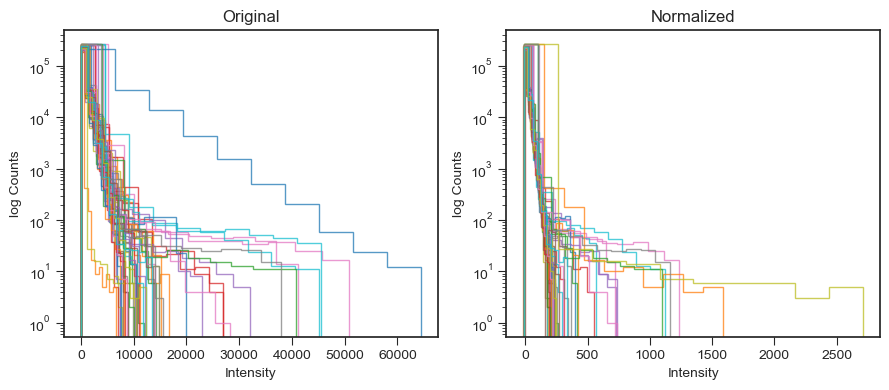

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for img_orig in tqdm(data['orig']):
    ax[0].hist(img_orig.flatten(), histtype='step', alpha=0.75)
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('log Counts')
ax[0].set_yscale('log')
ax[0].set_title('Original')

for img_norm in tqdm(data['norm']):
    ax[1].hist(img_norm.flatten(), histtype='step', alpha=0.75)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('log Counts')
ax[1].set_yscale('log')
ax[1].set_title('Normalized')
plt.tight_layout()
plt.show()

100%|██████████| 50/50 [00:00<00:00, 3847.35it/s]


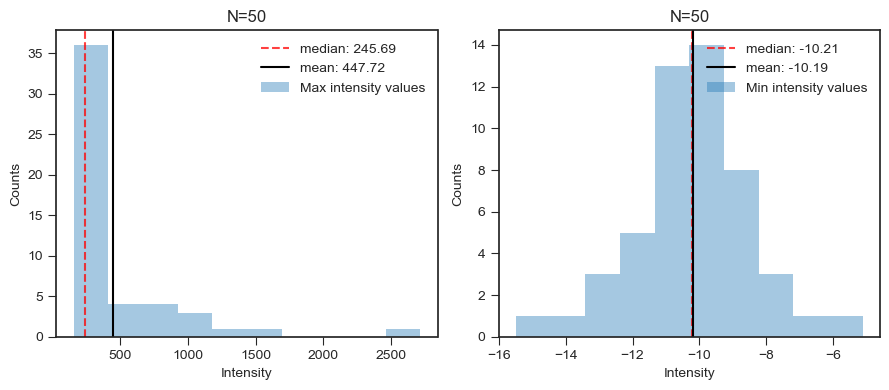

Min: 	 160.4
Max: 	 2711.8
Delta: 	 2551.4


In [10]:
max_intensity = []
min_intensity = []
for img_norm in tqdm(data['norm']):
    max_intensity.append(np.max(img_norm))
    min_intensity.append(np.min(img_norm))

# Plot side by side    
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].hist(max_intensity, alpha=0.4, label='Max intensity values')
ax[0].axvline(np.median(max_intensity), color='r', linestyle='dashed', alpha=0.75, label='median: {}'.format(np.round(np.median(max_intensity), 2)))
ax[0].axvline(np.mean(max_intensity), color='black', label='mean: {}'.format(np.round(np.mean(max_intensity), 2)))
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Counts')
ax[0].set_title('N=50')
ax[0].legend()

ax[1].hist(min_intensity, alpha=0.4, label='Min intensity values')
ax[1].axvline(np.median(min_intensity), color='r', linestyle='dashed', alpha=0.75, label='median: {}'.format(np.round(np.median(min_intensity), 2)))
ax[1].axvline(np.mean(min_intensity), color='black', label='mean: {}'.format(np.round(np.mean(min_intensity), 2)))
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Counts')
ax[1].set_title('N=50')
ax[1].legend()
plt.tight_layout()
plt.legend()
plt.show()


print('Min: \t', np.round(np.min(max_intensity), 2))
print('Max: \t', np.round(np.max(max_intensity), 2))
print('Delta: \t', np.round(np.max(max_intensity)-np.min(max_intensity), 2))

The intensity distribution looks already more aligned, but the range of the maximum intensity values is still quite high. 

Note that due to the extrapolation in the transformation process (see nyul.py), we now have negative minimum intensity values in the normalized images.

### Thresholding the minimum and maximum intensity value to the median   <a class="anchor" id="section7_2"></a>

We can further improve the intensity distribution by setting the minimum and maximum intensity value of each normalized image to the median.

Therefor, we set all intensity values greater than the median max intensity value of all normalized images to the median max intensity value and vice versa for the minimum intensity value. 

In [11]:
median_max = np.median(max_intensity)
median_min = np.median(min_intensity)

for img_norm in tqdm(data['norm']):
    img_norm[img_norm > median_max] = median_max
    img_norm[img_norm < median_min] = median_min

100%|██████████| 50/50 [00:00<00:00, 2067.99it/s]


100%|██████████| 50/50 [00:00<00:00, 220.31it/s]


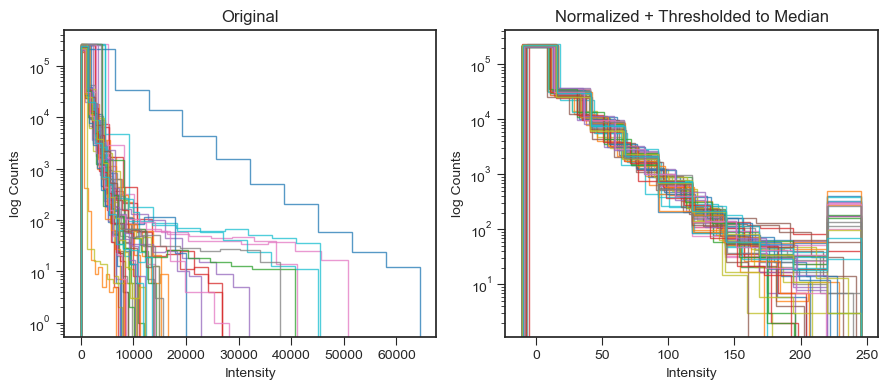

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot original
for img_orig in tqdm(data['orig']):
    ax[0].hist(img_orig.flatten(), histtype='step', alpha=0.75)
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('log Counts')
ax[0].set_yscale('log')
ax[0].set_title('Original')

# Plot normalized 
for img_norm in tqdm(data['norm']):
    ax[1].hist(img_norm.flatten(), histtype='step', alpha=0.75)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('log Counts')
ax[1].set_yscale('log')
ax[1].set_title('Normalized + Thresholded to Median')
plt.tight_layout()
plt.show()

### Recap   <a class="anchor" id="section7_3"></a>

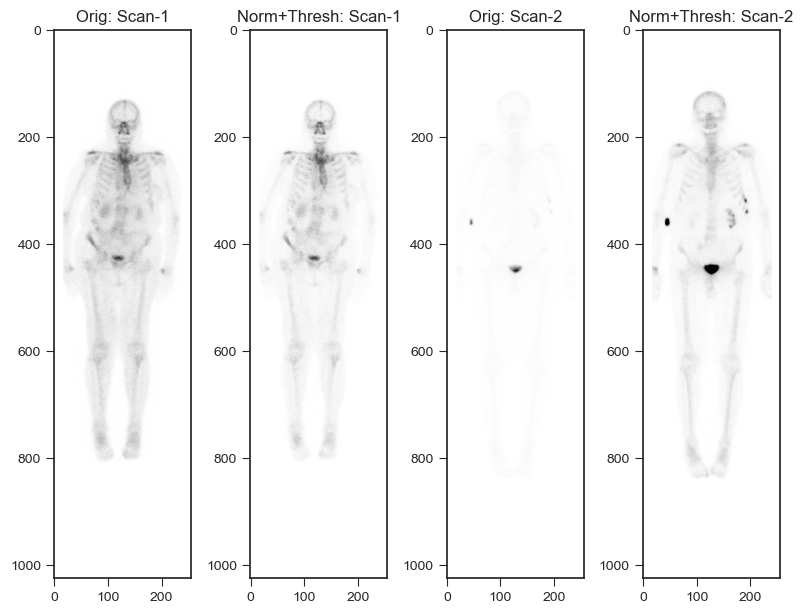

In [13]:
orig_example = dict(zip(data['uids'], data['orig']))
norm_example = dict(zip(data['uids'], data['norm']))
scan1 = 'img-24'
scan2 = 'img-30'

# Plot
fig, ax = plt.subplots(1, 4, figsize=(8, 10))
ax[0].imshow(orig_example[scan1])
ax[0].set_title('Orig: Scan-1')
ax[1].imshow(norm_example[scan1])
ax[1].set_title('Norm+Thresh: Scan-1')
ax[2].imshow(orig_example[scan2])
ax[2].set_title('Orig: Scan-2')
ax[3].imshow(norm_example[scan2])
ax[3].set_title('Norm+Thresh: Scan-2')
plt.tight_layout()
plt.show()

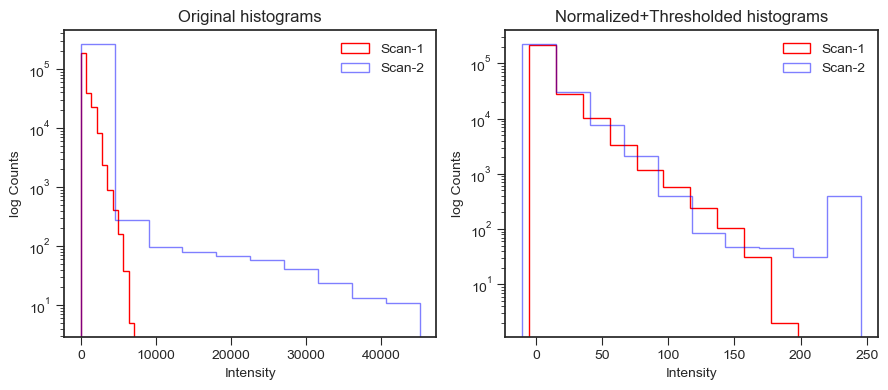

In [14]:
# Plot image histograms side by side
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].hist(orig_example[scan1].flatten(), histtype='step', ec='r', label='Scan-1')
ax[0].hist(orig_example[scan2].flatten(), histtype='step', ec='b', alpha=0.5, label='Scan-2')
ax[0].set_yscale('log')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('log Counts')
ax[0].legend()
ax[0].set_title('Original histograms')

ax[1].hist(norm_example[scan1].flatten(), histtype='step', ec='r', label='Scan-1')
ax[1].hist(norm_example[scan2].flatten(), histtype='step', ec='b', alpha=0.5, label='Scan-2')
ax[1].set_yscale('log')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('log Counts')
ax[1].legend()
ax[1].set_title('Normalized+Thresholded histograms')
plt.tight_layout()
plt.show()